In this kernel, we shall see if pretrained embeddings like Word2Vec, GLOVE and Fasttext, which are pretrained using billions of words could improve our accuracy score as compared to training our own embedding. We will compare the performance of models using these pretrained embeddings against the baseline model that doesn't use any pretrained embeddings in my previous kernel [here](https://www.kaggle.com/sbongo/for-beginners-tackling-toxic-using-keras).

![](https://qph.fs.quoracdn.net/main-qimg-3e812fd164a08f5e4f195000fecf988f)

Perhaps it's a good idea to briefly step in the world of word embeddings and see what's the difference between Word2Vec, GLOVE and Fasttext.

Embeddings generally represent geometrical encodings of words based on how frequently appear together in a text corpus. Various implementations of word embeddings described below differs in the way as how they are constructed.

**Word2Vec**

The main idea behind it is that you train a model on the context on each word, so similar words will have similar numerical representations.

Just like a normal feed-forward densely connected neural network(NN) where you have a set of independent variables and a target dependent variable that you are trying to predict, you first break your sentence into words(tokenize) and create a number of pairs of words, depending on the window size. So one of the combination could be a pair of words such as ('cat','purr'), where cat is the independent variable(X) and 'purr' is the target dependent variable(Y) we are aiming to predict.

We feed the 'cat' into the NN through an embedding layer initialized with random weights, and pass it through the softmax layer with ultimate aim of predicting 'purr'. The optimization method such as SGD minimize the loss function "(target word | context words)" which seeks to minimize the loss of predicting the target words given the context words. If we do this with enough epochs, the weights in the embedding layer would eventually represent the vocabulary of word vectors, which is the "coordinates" of the words in this geometric vector space.

![](https://i.imgur.com/R8VLFs2.png)

The above example assumes the skip-gram model. For the Continuous bag of words(CBOW), we would basically be predicting a word given the context. 

**GLOVE**

GLOVE works similarly as Word2Vec. While you can see above that Word2Vec is a "predictive" model that predicts context given word, GLOVE learns by constructing a co-occurrence matrix (words X context) that basically count how frequently a word appears in a context. Since it's going to be a gigantic matrix, we factorize this matrix to achieve a lower-dimension representation. There's a lot of details that goes in GLOVE but that's the rough idea.

**FastText**

FastText is quite different from the above 2 embeddings. While Word2Vec and GLOVE treats each word as the smallest unit to train on, FastText uses n-gram characters as the smallest unit. For example, the word vector ,"apple", could be broken down into separate word vectors units as "ap","app","ple". The biggest benefit of using FastText is that it generate better word embeddings for rare words, or even words not seen during training because the n-gram character vectors are shared with other words. This is something that Word2Vec and GLOVE cannot achieve.


Let's start off with the usual importing pandas, etc

In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import matplotlib.pyplot as plt
%matplotlib inline
import gensim.models.keyedvectors as word2vec
import gc

Using TensorFlow backend.


Some preprocessing steps that we have taken in my earlier kernel.

In [2]:
train = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv')
test = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test.csv')
embed_size=0

In [3]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

In [4]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [5]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

Since we are going to evaluate a few word embeddings, let's define a function so that we can run our experiment properly. I'm going to put some comments in this function below for better intuitions.

Note that there are quite a few GLOVE embeddings in Kaggle datasets, and I feel that it would be more applicable to use the one that was trained based on Twitter text. Since the comments in our dataset consists of casual, user-generated short message, the semantics used might be very similar. Hence, we might be able to capture the essence and use it to produce a good accurate score.

Similarly, I have used the Word2Vec embeddings which has been trained using Google Negative News text corpus, hoping that it's negative words can work better in our "toxic" context.

In [6]:
def loadEmbeddingMatrix(typeToLoad):
        #load different embedding file from Kaggle depending on which embedding 
        #matrix we are going to experiment with
        if(typeToLoad=="glove"):
            EMBEDDING_FILE='../input/glove-twitter/glove.twitter.27B.25d.txt'
            embed_size = 25
        elif(typeToLoad=="word2vec"):
            word2vecDict = word2vec.KeyedVectors.load_word2vec_format("../input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin", binary=True)
            embed_size = 300
        elif(typeToLoad=="fasttext"):
            EMBEDDING_FILE='../input/fasttext/wiki.simple.vec'
            embed_size = 300

        if(typeToLoad=="glove" or typeToLoad=="fasttext" ):
            embeddings_index = dict()
            #Transfer the embedding weights into a dictionary by iterating through every line of the file.
            f = open(EMBEDDING_FILE)
            for line in f:
                #split up line into an indexed array
                values = line.split()
                #first index is word
                word = values[0]
                #store the rest of the values in the array as a new array
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs #50 dimensions
            f.close()
            print('Loaded %s word vectors.' % len(embeddings_index))
        else:
            embeddings_index = dict()
            for word in word2vecDict.wv.vocab:
                embeddings_index[word] = word2vecDict.word_vec(word)
            print('Loaded %s word vectors.' % len(embeddings_index))
            
        gc.collect()
        #We get the mean and standard deviation of the embedding weights so that we could maintain the 
        #same statistics for the rest of our own random generated weights. 
        all_embs = np.stack(list(embeddings_index.values()))
        emb_mean,emb_std = all_embs.mean(), all_embs.std()
        
        nb_words = len(tokenizer.word_index)
        #We are going to set the embedding size to the pretrained dimension as we are replicating it.
        #the size will be Number of Words in Vocab X Embedding Size
        embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
        gc.collect()

        #With the newly created embedding matrix, we'll fill it up with the words that we have in both 
        #our own dictionary and loaded pretrained embedding. 
        embeddedCount = 0
        for word, i in tokenizer.word_index.items():
            i-=1
            #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
            embedding_vector = embeddings_index.get(word)
            #and store inside the embedding matrix that we will train later on.
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
                embeddedCount+=1
        print('total embedded:',embeddedCount,'common words')
        
        del(embeddings_index)
        gc.collect()
        
        #finally, return the embedding matrix
        return embedding_matrix


The function would return a new embedding matrix that has the loaded weights from the pretrained embeddings for the common words we have, and randomly initialized numbers that has the same mean and standard deviation for the rest of the weights in this matrix.

Let's move on and load our first embeddings from Word2Vec.

In [7]:
embedding_matrix = loadEmbeddingMatrix('word2vec')

Loaded 3000000 word vectors.
total embedded: 66078 common words


In [8]:
embedding_matrix.shape

(210337, 300)

With the embedding weights, we can proceed to build a LSTM layer. The whole architecture is pretty much the same as the previous one I have done in the earlier kernel here, except that I have turned the LSTM into a bidirectional one, and added a dropout factor to it. 

We start off with defining our input layer. By indicating an empty space after comma, we are telling Keras to infer the number automatically.

In [9]:
inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier

Next, we pass it to our Embedding layer, where we use the "weights" parameter to indicate the use of the pretrained embedding weights we have loaded and the "trainable" parameter to tell Keras **not to retrain** the embedding layer.

In [10]:
x = Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False)(inp)

Next, we pass it to a LSTM unit. But this time round, we will be using a Bidirectional LSTM instead because there are several kernels which shows a decent gain in accuracy by using Bidirectional LSTM.

How does Bidirectional LSTM work? 

![](https://i.imgur.com/jaKiP0S.png)

Imagine that the LSTM is split between 2 hidden states for each time step. As the sequence of words is being feed into the LSTM in a forward fashion, there's another reverse sequence that is feeding to the different hidden state at the same time. You might noticed later at the model summary that the output dimension of LSTM layer has doubled to 120 because 60 dimensions are used for forward, and another 60 are used for reverse.

The greatest advantage in using Bidirectional LSTM is that when it runs backwards you preserve information from the future and using the two hidden states combined, you are able in any point in time to preserve information from both past and future.


We are also introducing 2 more new mechanisms in this notebook: **LSTM Drop out and recurrent drop out.**

Why are we using dropout? You might have noticed that it's easy for LSTM to overfit, and in my previous notebook, overfitting problem starts to surface in just 2 epochs! Drop out is not something new to most of us, and these mechanisms applies the same dropout principles in a LSTM context.

![](https://i.imgur.com/ksSyArD.png)
LSTM Dropout is a probabilistic drop out layer on the inputs in each time step, as depict on the left diagram(arrows pointing upwards). On the other hand, recurrent drop out is something like a dropout mask that applies drop out between the hidden states throughout the recursion of the whole LSTM network, which is depicted on the right diagram(arrows pointing to the right). 

These mechanisms could be set via the "dropout" and "recurrent_dropout" parameters respectively. Please ignore the colors in the picture.


In [11]:
x = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)

Okay! With the LSTM behind us, we'll feed the output into the rest of the layers which we have done so in the previous kernel. 

In [12]:
x = GlobalMaxPool1D()(x)

In [13]:
x = Dropout(0.1)(x)

In [14]:
x = Dense(50, activation="relu")(x)

In [15]:
x = Dropout(0.1)(x)

In [16]:
x = Dense(6, activation="sigmoid")(x)

In [17]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

It's a good idea to see the whole architecture of the network before training as you wouldn't want to waste your precious time training on the wrong set-up.

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 300)          63101100  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 120)          173280    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 120)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                6050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
__________

Finally, we fire off the training process by aiming to run for 4 epochs with a batch size of 32. We save the training and validation loss in a variable so we can take a look and see if there's overfitting.

In [19]:
#batch_size = 32
#epochs = 4
#hist = model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

The training of the model will take longer than what Kaggle kenel allows. I have pre-run it, and this is the result that you should roughly see

Train on 143613 samples, validate on 15958 samples

Epoch 1/4
143613/143613 [==============================] - 2938s 20ms/step - loss: 0.0843 - acc: 0.9739 - val_loss: 0.0630 - val_acc: 0.9786

Epoch 2/4
143613/143613 [==============================] - 3332s 23ms/step - loss: 0.0573 - acc: 0.9805 - val_loss: 0.0573 - val_acc: 0.9803

Epoch 3/4
143613/143613 [==============================] - 3119s 22ms/step - loss: 0.0513 - acc: 0.9819 - val_loss: 0.0511 - val_acc: 0.9817

Epoch 4/4
143613/143613 [==============================] - 3137s 22ms/step - loss: 0.0477 - acc: 0.9827 - val_loss: 0.0498 - val_acc: 0.9820


The result isn't too shabby but it's about the same as the baseline model which we train our own embedding. What about the other pretrained embeddings such as GLOVE and FastText? Let's try them out.

Over here, we are not going to repeat the whole process again. If you are running the notebook yourself, simply replace

In [20]:
#loadEmbeddingMatrix('word2vec')

with

In [21]:
#loadEmbeddingMatrix('glove') #for GLOVE or
#loadEmbeddingMatrix('fasttext') #for fasttext

to load the pretrained embedding from the different sources. For the sake of our benchmarking. I have pre-run it and collected all the results.

**GLOVE:**

Train on 143613 samples, validate on 15958 samples

Epoch 1/4
143613/143613 [==============================] - 2470s 17ms/step - loss: 0.1160 - acc: 0.9656 - val_loss: 0.0935 - val_acc: 0.9703

Epoch 2/4
143613/143613 [==============================] - 2448s 17ms/step - loss: 0.0887 - acc: 0.9721 - val_loss: 0.0800 - val_acc: 0.9737

Epoch 3/4
143613/143613 [==============================] - 2410s 17ms/step - loss: 0.0799 - acc: 0.9745 - val_loss: 0.0753 - val_acc: 0.9757

Epoch 4/4
143613/143613 [==============================] - 2398s 17ms/step - loss: 0.0753 - acc: 0.9760 - val_loss: 0.0724 - val_acc: 0.9768


**Fasttext:**

Train on 143613 samples, validate on 15958 samples

Epoch 1/4
143613/143613 [==============================] - 2800s 19ms/step - loss: 0.0797 - acc: 0.9757 - val_loss: 0.0589 - val_acc: 0.9795

Epoch 2/4
143613/143613 [==============================] - 2756s 19ms/step - loss: 0.0561 - acc: 0.9808 - val_loss: 0.0549 - val_acc: 0.9804

Epoch 3/4
143613/143613 [==============================] - 2772s 19ms/step - loss: 0.0507 - acc: 0.9819 - val_loss: 0.0548 - val_acc: 0.9811

Epoch 4/4
143613/143613 [==============================] - 2819s 20ms/step - loss: 0.0474 - acc: 0.9828 - val_loss: 0.0507 - val_acc: 0.9817


And of course, the same **baseline** model which doesn't use any pretrained embeddings, taken straight from the previous kenel except that we ran for 4 epochs:

Train on 143613 samples, validate on 15958 samples

Epoch 1/4
143613/143613 [==============================] - 5597s 39ms/step - loss: 0.0633 - acc: 0.9788 - val_loss: 0.0480 - val_acc: 0.9825

Epoch 2/4
143613/143613 [==============================] - 5360s 37ms/step - loss: 0.0448 - acc: 0.9832 - val_loss: 0.0464 - val_acc: 0.9828

Epoch 3/4
143613/143613 [==============================] - 5352s 37ms/step - loss: 0.0390 - acc: 0.9848 - val_loss: 0.0470 - val_acc: 0.9829

Epoch 4/4
129984/143613 [==============================] - 5050s 37ms/step - loss: 0.0386 - acc: 0.9858 - val_loss: 0.0478 - val_acc: 0.9830

It's easier if we plot the losses into graphs.

In [22]:
all_losses = {
'word2vec_loss': [0.084318213647104789,
  0.057314205012433353,
  0.051338302593577821,
  0.047672802178572039],
 'word2vec_val_loss': [0.063002561892695971,
  0.057253835496480658,
  0.051085027624451551,
  0.049801279793734249],
'glove_loss': [0.11598931579683543,
  0.088738223480436862,
  0.079895263566000005,
  0.075343037429358703],
 'glove_val_loss': [0.093467933030432285,
  0.080007083813922117,
  0.075349041991106688,
  0.072366507668134517],
 'fasttext_loss': [0.079714499498945865,
  0.056074704045674786,
  0.050703874653286324,
  0.047420131195761134],
 'fasttext_val_loss': [0.058888281775148932,
  0.054906051694414926,
  0.054768857866843601,
  0.050697043558286421],
 'baseline_loss': [0.063304489498915865,
  0.044864004045674786,
  0.039013874651286124,
  0.038630130175761134],
 'baseline_val_loss': [0.048044281075148932,
  0.046414051594414926,
  0.047058757860843601,
  0.047886043558285421]
}

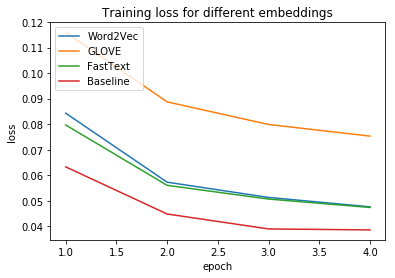

In [23]:
#f, ax = plt.subplots(1)
epochRange = np.arange(1,5,1)
plt.plot(epochRange,all_losses['word2vec_loss'])
plt.plot(epochRange,all_losses['glove_loss'])
plt.plot(epochRange,all_losses['fasttext_loss'])
plt.plot(epochRange,all_losses['baseline_loss'])
plt.title('Training loss for different embeddings')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Word2Vec', 'GLOVE','FastText','Baseline'], loc='upper left')
plt.show()

Well, it certainly looks like the baseline has the minimum training loss. But before we close this case and pick the baseline model as the winner, this plot does not tell the full story as there seems to be some overfitting in the baseline model. It appears that from the 2nd epoch, overfitting has started to slip in as the validation loss has become higher than training loss.

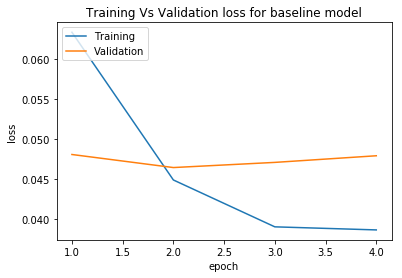

In [24]:
epochRange = np.arange(1,5,1)
plt.plot(epochRange,all_losses['baseline_loss'])
plt.plot(epochRange,all_losses['baseline_val_loss'])
plt.title('Training Vs Validation loss for baseline model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

What about the rest? Let's plot all the training/validation loss plots out to compare side by side.

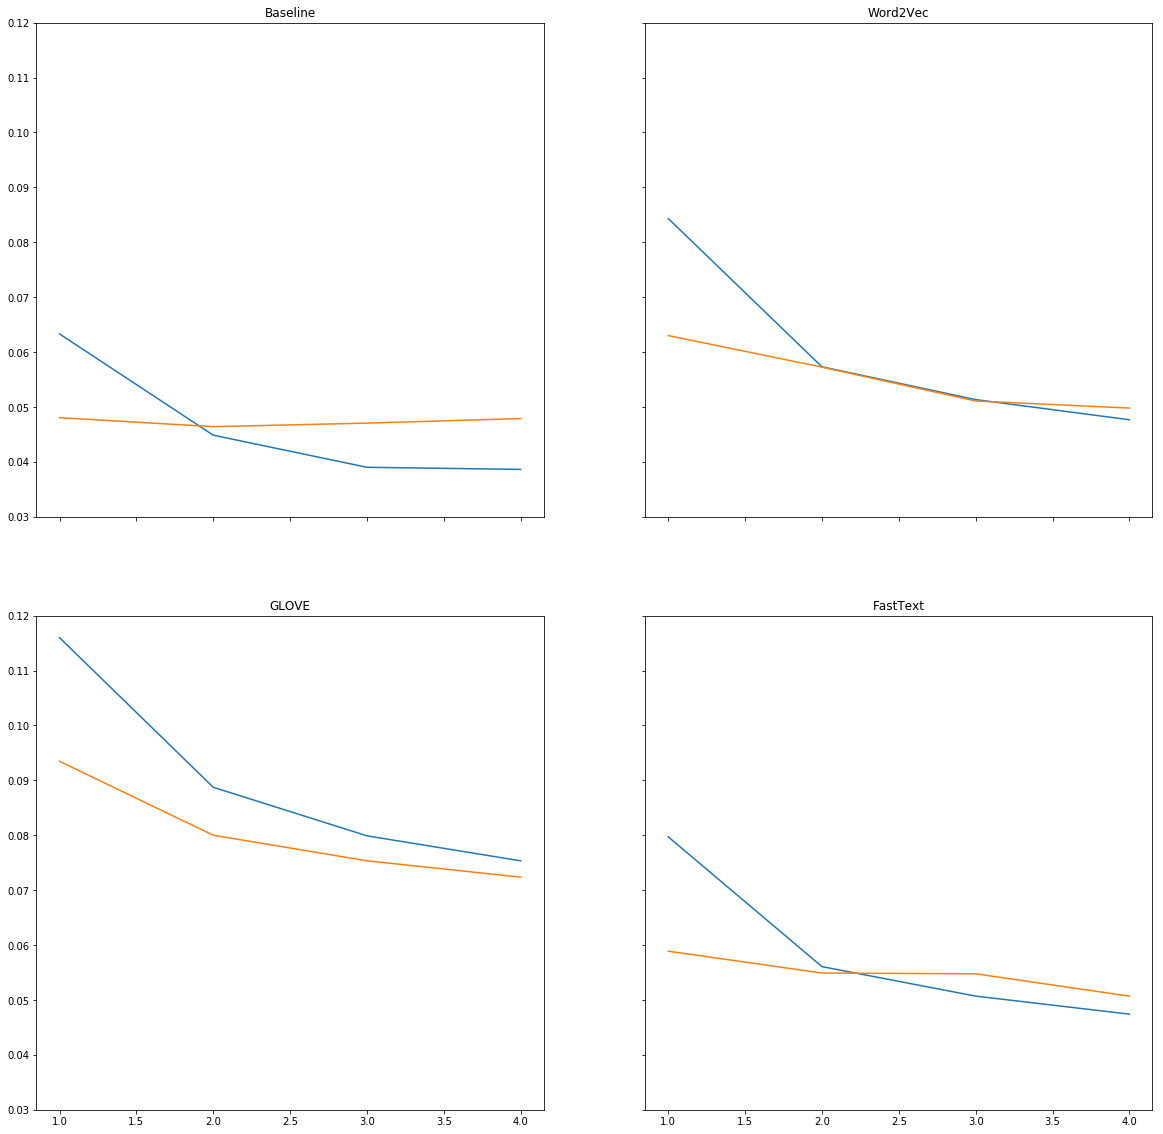

In [25]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row',figsize=(20, 20))

plt.title('Training Vs Validation loss for all embeddings')
ax1.plot(epochRange,all_losses['baseline_loss'])
ax1.plot(epochRange,all_losses['baseline_val_loss'])
ax1.set_title('Baseline')
ax1.set_ylim(0.03, 0.12)

ax2.plot(epochRange,all_losses['word2vec_loss'])
ax2.plot(epochRange,all_losses['word2vec_val_loss'])
ax2.set_title('Word2Vec')
ax2.set_ylim(0.03, 0.12)

ax3.plot(epochRange,all_losses['glove_loss'])
ax3.plot(epochRange,all_losses['glove_val_loss'])
ax3.set_title('GLOVE')
ax3.set_ylim(0.03, 0.12)


ax4.plot(epochRange,all_losses['fasttext_loss'])
ax4.plot(epochRange,all_losses['fasttext_val_loss'])
ax4.set_title('FastText')
ax4.set_ylim(0.03, 0.12)

plt.show()

With all the losses laid out, it's easy to see which the best option is. While it appears that GLOVE still some room to go before it overfits, the loss is high compared to the rest. On the other hand, Word2Vec and FastText starts to overfit at the 4rd and 3rd epochs respectively. So which one would you pick as the winner? In my opinion, **still the baseline model.**

So what went wrong? Aren't pretrained embeddings supposed to improve because it's trained with billions of words from tons of feature-rich corpus?

One probability is that these pretrained embeddings are not trained against text in the same context so the number of common words between our text and text that these pretrained embeddings were trained would be low. Let's plot the number of words we are using in the embedding layer.

In [26]:
wordCount = {'word2vec':66078,'glove':81610,'fasttext':59613,'baseline':210337}

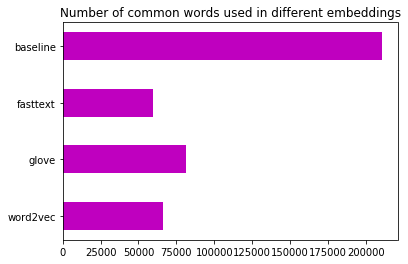

In [27]:
ind = np.arange(0,4,1)  # the x locations for the groups
width = 0.35       # the width of the bars

plt.title('Number of common words used in different embeddings')
embNames = list(wordCount.keys())
embVals = list(wordCount.values())
plt.barh(ind,embVals,align='center', height=0.5, color='m',tick_label=embNames)
plt.show()

From the above bar chart, it's obvious that the baseline would have the most words since the embedding layer is trained using the words in the dataset. The important takeaway is that the pretrained embeddings only contains about 60,000 words in common(less than half of baseline) and the embedding layer that is built from these pretrained weights couldn't represent the training data well enough.

Although building your own embedding takes a longer time, it might be worthwhile because it builds specifically for your context.

And that finally wraps up this kernel! I hope someone learnt something in this kernel. If you spot an error, feel free to let me know by commenting below. 

Thanks for reading and good luck in the competition!

**TODO:**
1. There are many pretrained embeddings in Kaggle, and they are trained in different contexts of text corpus. You could try out other pretrained embeddings that is more suitable to the dataset in our competition.
2. Introduce LSTM drop out and recurrent drop out in baseline model, and tune the dropout rate to decrease overfitting.